# Analysis of Adversarial Examples

## Step-by-Step tutorial for Least Likely Class method of generating adversarial samples

### What are Adversarial Examples ? 

Deep learning networks are now a days state of the art for visual and speech related tasks. Here we will talk specifically about image recognition task by CNNs. The CNNs are almost used everywhere now a days for image recognition and are present state of the art for ImageNet challenge. Given an image, we want the network to predict the correct label class for the image. Now, given that the network predicts the correct label for an image, an obvious curiosity is to add some noise (changes to the image pixels small enough to be differentiated by human eyes) to image, and recheck the network's prediction on the image. It has been found that the netowork predictions are robust to injecting small random noise (e.g. sampled from normal distributions) , which is in fact what is desired. 

But it has been shown that not all the small noise added to the image retains the correct prediction. Very specific types of small noise when added to the image, produces interesting predictions. These are known as  ***adversarial examples*** and are direct threat as they can be easily used to perform attacks on machine learning systems and the most crucial point is that the adversary does not even need to know the the underlying model. 

### Least Likely Class Method 

In this method of generating adversarial examples, we take an image and update it in such a way so that the network classifies it wrongly and also at the same time, clip the gradient updates in such a way so as to prevent the update image to become different from input image.

We can select a class which has the least score for the input image and then construct adversarial example to classify the same image to that class with high confidence. We select the least like class to get an idea of extent to which the network can mistake the classification (e.g. classify a car to a church). To do so, we perform the following steps:
1. Select the target class *T* (preferably least likely class)
2. Feed forward the original image to the network to generate the class scores.
3. Calculate the loss function treating *T* as the correct prediction.
4. Compute the gradient of loss wrt image and update the image with corresponding gradient.
5. Clip the updated image to lie in $\epsilon$ neighbourhood of the original image
6. Repeat step 2-5 till the loss function converges.

$ \epsilon $ neighbourhood is defined as 
$$ X_{new} = Clip( Clip( X_{new},X_{original}-\epsilon,X_{original}+\epsilon),0,1) $$

assuming that the pixel values are normalised to lie in the range [0,1].

We can adjust the value of $ \epsilon $ to decide the maximum distance we want to keep between the modified image and the original image.   

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import json
import urllib
urllib.URLopener().retrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json','Image_Net.json')
with open('Image_Net.json') as file:
    image_labels = json.load(file)

In [3]:
# Following function classifies an input image given the pretrained AlexNet
def classify(input_image):
    # Pretrained AlexNet architecture with SoftMax layer at the end
    model = nn.Sequential(
            models.alexnet(pretrained = True),
            nn.Softmax(),
            )
    
    # Input Variable
    input = Variable(torch.from_numpy(input_image).float())
    # Forward Pass on the model with the input image
    output = model.forward(input)
    # Final Scores
    final_scores = output.sort()[0].data.numpy()
    labels = output.sort()[1].data.numpy()
    top_5_labels,top_5_scores = [],[]
    for i in range(5):
        index = -1*(i+1)
        top_5_labels.append(image_labels[labels[0,index]][:15])
        top_5_scores.append(final_scores[0,index])
    # top_5 contains the top 5 labels with highest scores
    fig = plt.subplot()
    x = np.arange(5)
    plt.bar(x, top_5_scores)
    plt.xticks(x,top_5_labels,rotation = 'vertical')
    plt.show()
    

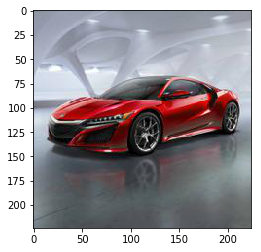

In [4]:
image_path = "Images/car.jpg"
# Image Path 
image = Image.open(image_path)
image_in = np.asarray(image)
fig = plt.subplot()
fig.imshow(image_in)
plt.show()
# The image is padded to make it of size (224,224,3) (Input size for AlexNet)
# The image can also be cropped or directly resized but here, to make it more correct, I resize it 
# while conserving the aspect ratio.

In [5]:
image_in = np.expand_dims(np.transpose(image_in,axes=(2,0,1)),axis=0)
print(image_in.shape)
# image_in is the transformed input of the shape (1,3,224,224)
# 1 at axis 0 is for the purpose of batch size, since it is just one image for us, hence 1.

(1, 3, 224, 224)


In [6]:
norm_mean = np.asarray([0.485, 0.456, 0.406]).reshape([1,3,1,1])
norm_std = np.asarray([0.229, 0.224, 0.225]).reshape([1,3,1,1])
# These are just the mean and standard deviation pytorch uses for normalisation of image input of 
# its pretrained models.

In [7]:
# Preprocessing the image before passing it to the network
image_in = image_in/255.0 # Values in image_in are now in the range [0,1]
image_in = (image_in-norm_mean)/norm_std # Necessary normalisation

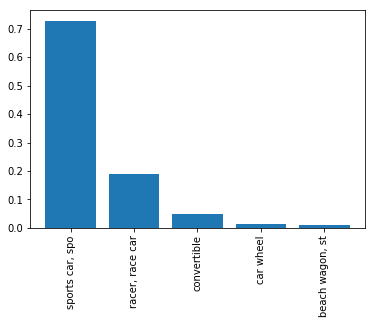

In [8]:
classify(image_in)

In [9]:
# Defining model as a pretrained alexnet
model = models.alexnet(pretrained = True)

# Input image is the torch.autograd Variable of having torch tensor of type float() and having the value of the 
# processed image above
input_im = Variable(torch.from_numpy(image_in).float(),requires_grad=True)
target = Variable(torch.from_numpy(np.matrix([497])).resize_(1),requires_grad=False)
# The value of the target variable is just random class label of ImageNet we want the network to misclassify 
# the image into. 

The `` requires_grad = True `` in input_im is necessary as we will differentiate the loss function w.r.t. the input image.  

In [10]:
learning_rate = 1e-3
epsilon = 0.05
EPOCH = 400
# Number of epochs to train 
optimizer  = torch.optim.Adam(params = [input_im], lr = learning_rate)
# Torch Adam optimizer to update the input_im Variable paramters with the given learning rate.
loss = nn.CrossEntropyLoss()
# Cross Entropy Loss function

In [11]:
# Minimizing the loss function by modifying the input image
for i in range(EPOCH):
    output = model.forward(input_im) # Feed-Forward Pass on the network using the input image
    lossval = loss(output,target) # Calculating the Cross Entropy Loss
    optimizer.zero_grad()
    lossval.backward() # Evaluating the Gradients w.r.t.input image
    optimizer.step() # Propagating the Gradients to the input image
    # Clipping the image
    input_im.data = torch.from_numpy((np.clip(np.clip(input_im.data.numpy(),image_in-epsilon,image_in+epsilon),(0-norm_mean)/norm_std,(1-norm_mean)/norm_std))).float()
    if (i+1)%40 == 0:
        print("Loss at Epoch %d = %f" % (i+1 ,lossval.data[0]))


Loss at Epoch 40 = 10.928082
Loss at Epoch 80 = 7.010055
Loss at Epoch 120 = 1.975116
Loss at Epoch 160 = 0.418654
Loss at Epoch 200 = 0.420938
Loss at Epoch 240 = 0.522492
Loss at Epoch 280 = 0.092809
Loss at Epoch 320 = 0.272728
Loss at Epoch 360 = 0.096323
Loss at Epoch 400 = 0.107256


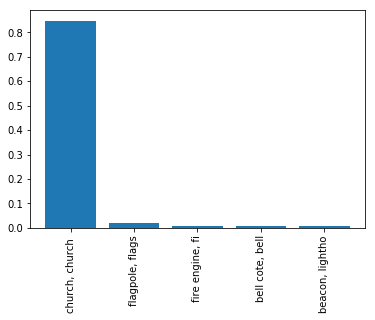

In [12]:
classify(input_im.data.numpy())

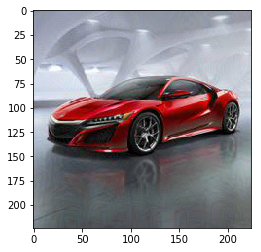

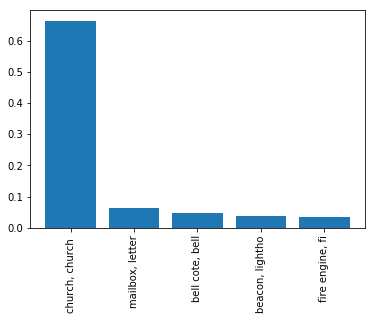

In [13]:
# Regenerating the image to check whether its the same or not.
image_tr = np.transpose(np.squeeze((input_im.data.numpy()*norm_std)+norm_mean),axes=(1,2,0))
image_tr = (image_tr*255.0).astype(np.uint8)
fig = plt.subplot()
fig.imshow(image_tr)
plt.show()
image_tr = np.expand_dims(np.transpose(image_tr,axes=(2,0,1)),axis=0)
image_tr = image_tr/255.0 # Values in image_in are now in the range [0,1]
image_tr = (image_tr-norm_mean)/norm_std # Necessary normalisation
classify(image_tr)
